# Introduction

This notebook introduces GIST-V8, my eighth attempt at a GIST sampler with a stopping criterion based on the virial of the Hamiltonian with biased progressive sampling.  The virial is defined as 

$$2 \cdot \rho^T \cdot \theta$$

where $\rho$ is the momentum vector and $\theta$ is the position vector.  The details of the theory of this formula are lost to me since last summer, but Nawaf knows. The virial bounces about zero along a leapfrog trajectory.  I've settled on using three sign switches in the virial as a reasonable stopping criterion; justification below.

This stopping criterion is similar to using sign switches of $\rho^T \cdot \nabla U(\theta)$ as a stopping criterion, as Sherlock et al did in The Apogee to Apogee Path Sampler. In the apogee paper, the authors produced some theory that helps determine a good guess for the number of sign switches.

Below, I present just a few simulations of three different samplers. The class in the style of Bob's adaptive-hmc/gist_paper's classes is in the Appendix below; links lead to code in github repository.

* [GIST-U](https://github.com/roualdes/mcmcexperiments/blob/main/gist_uturn2.py)
* [GIST-V](https://github.com/roualdes/mcmcexperiments/blob/main/gist_virial4.py)
* [GIST-V8](https://github.com/roualdes/mcmcexperiments/blob/main/gist_virial8.py)

The simulations are meant to give a better understanding of the sampler, not to be a complete empirical evaluation/comparison.

**todo**:
* do more simulations; I don't have time, nor the compute, for more simulations right now.

GIST-U is a u-turn based GIST sampler, where the proposed state is sampled during the formation of the forward trajectory using a Multinoulli distribution over the Hamiltonians at each leapfrog point.  

GIST-V uses 3 sign switches of the virial as the stopping criterion and also samples during the formation of the forward trajectory using a Multinoulli distribution.  

GIST-V8 uses an adaptation of 3 sign switches of the virial and samples during the formation of the forward pass, but also samples in a manner analogous to Stan's biased progressive sampling; see [Michael Betancourt's A Conceptual Introduction to
Hamiltonian Monte Carlo, Appendix A.3.2](https://arxiv.org/abs/1701.02434).  During the formation of the forward trajectory, states are Multinoulli sampled within segments of `segment_length` $ > 1$ and then segments themselves are sampled, such that segments further from the initial point $\theta_0$ are more likely.  Stan defines these segments as doublings in the number of leapfrog steps.  But as far as I can tell, the math works just the same no matter how we define these segments, so long as more than one state lives within each segment.

So technically, GIST-V8 uses as a stopping criterion, the end of the next segment after 3 sign switches.  This has some benefits in terms of acceptance rates and whether or not we need to calculate a backward trajectory at all.  Sometimes segments end at exactly 3 sign switches.

**todo**:
* understand theory of virial better
* re-produce Betancourt's math

# Simulations

In [75]:
from pathlib import Path
from bsmodel import BSModel
from gist_uturn2 import GISTU2  # GIST-U
from gist_virial4 import GISTV4 # GIST-V
from gist_virial8 import GISTV8 # GIST-V8

import bridgestan as bs
import cmdstanpy as csp
import matplotlib.pyplot as plt
import numpy as np
import tools as tls

import json
import pprint
import yaml
import time
import sys

In [76]:
with open("config.yaml") as f:
    cfg = yaml.safe_load(f)

pprint.pp(cfg)
bs.set_bridgestan_path(Path(cfg["bs_path"]).expanduser())
stan_file, data_file = tls.get_stan_files(cfg)

bs_model = BSModel(stan_file = stan_file, data_file = data_file)
tls.stop_griping()

{'print': True,
 'digits': 4,
 'iterations': 1000,
 'warmup': 500,
 'replications': 20,
 'seed': None,
 'stepsize': 0.24,
 'switch_limit': 3,
 'segment_length': 2,
 'db': 'experiments.db',
 'bs_path': '~/bridgestan',
 'model_path': 'stan',
 'model_name': 'normal',
 'init': {'warmup': 10000, 'iterations': 20000}}


`model_name` here defines a 10-dimensional standard Normal distribution.

In [77]:
gistu = GISTU2(bs_model, cfg["stepsize"], cfg["seed"])
gistv = GISTV4(bs_model, cfg["stepsize"], cfg["seed"], switch_limit = cfg["switch_limit"])
gistv8 = GISTV8(bs_model, cfg["stepsize"], cfg["seed"], switch_limit = cfg["switch_limit"], segment_length = cfg["segment_length"])
csp_model = csp.CmdStanModel(stan_file = stan_file)
stan = csp_model.sample(data = data_file,
                           chains = 1,
                           metric = "unit_e",
                           step_size = cfg["stepsize"],
                           iter_sampling = cfg["iterations"],
                           iter_warmup = cfg["warmup"],
                           adapt_engaged = False,
                           show_progress = False,
                           show_console = False)

In [78]:
du = gistu.sample_constrained(cfg["warmup"] + cfg["iterations"])
dv = gistv.sample_constrained(cfg["warmup"] + cfg["iterations"])
dv8 = gistv8.sample_constrained(cfg["warmup"] + cfg["iterations"])

In [79]:
thetas_u = du["thetas"][cfg["warmup"]:, :]
thetas_v = dv["thetas"][cfg["warmup"]:, :]
thetas_v8 = dv8["thetas"][cfg["warmup"]:, :]
thetas_stan = stan.draws(concat_chains = True)[:, 7:]

## Means

In [80]:
{"GIST-U": np.round(np.mean(thetas_u, axis = 0), 2),
 "GIST-V": np.round(np.mean(thetas_v, axis = 0), 2),
 "GIST-V8": np.round(np.mean(thetas_v8, axis = 0), 2),
 "Stan": np.round(np.mean(thetas_stan, axis = 0), 2)}

{'GIST-U': array([ 0.  , -0.05,  0.01, -0.03, -0.01,  0.01, -0.05, -0.  ,  0.04,
         0.  ]),
 'GIST-V': array([-0.04, -0.01,  0.01,  0.02,  0.06,  0.01, -0.01,  0.02,  0.02,
         0.01]),
 'GIST-V8': array([-0.05,  0.01, -0.01,  0.02, -0.01,  0.02, -0.02,  0.03, -0.01,
         0.07]),
 'Stan': array([ 0.04, -0.01,  0.01,  0.02, -0.  , -0.02, -0.05, -0.01,  0.03,
        -0.04])}

## Standard Deviations

In [81]:
{"GIST-U": np.round(np.std(thetas_u, axis = 0), 2),
 "GIST-V": np.round(np.std(thetas_v, axis = 0), 2),
 "GIST-V8": np.round(np.std(thetas_v8, axis = 0), 2),
 "Stan": np.round(np.std(thetas_stan, axis = 0), 2)}

{'GIST-U': array([1.07, 1.06, 1.  , 1.02, 0.95, 1.01, 1.06, 0.99, 1.03, 1.05]),
 'GIST-V': array([0.97, 1.02, 0.95, 0.96, 0.99, 0.99, 1.  , 1.05, 1.02, 1.01]),
 'GIST-V8': array([0.99, 1.02, 1.05, 0.94, 1.01, 1.  , 1.05, 0.96, 0.94, 1.  ]),
 'Stan': array([0.96, 1.07, 0.93, 1.03, 1.03, 0.98, 0.97, 0.95, 0.96, 1.02])}

## Distribution of Trajectory Lengths per iteration

The following plot depicts the distribution of the number of leapfrog steps in a forward trajectory per iteration for the three samplers.  Notice that the virial stopping criterion with 3 sign switches produces a very similar distribution to that of GIST-U.  This connection between the virial stopping criterion and the u-turn stopping criterion holds best for Normal distributions, and slightly less well for non-normal distributions. But from my not-yet-reproducible experience, the virial stopping criterion produces a much more uniform distribution than does the apogee stopping criterion.

**todo**:
* evaluate apgoee stopping criterion 
* make a pais plot instead of histogram; maybe distributions look similar but virial produces longer trajectories when u-turn produces short and vice versa

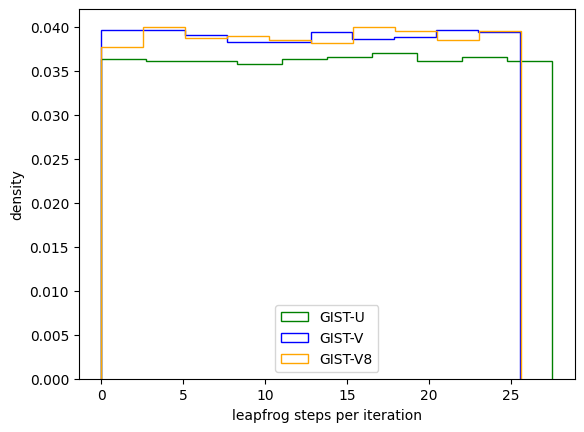

In [82]:
plt.hist(du["forward_steps"], color = "green", label = "GIST-U", histtype = "step", density = True)
plt.hist(dv["forward_steps"], color = "blue", label = "GIST-V", histtype = "step", density = True)
plt.hist(dv8["forward_steps"], color = "orange", label = "GIST-V8", histtype = "step", density = True)
plt.legend()
plt.ylabel("density")
plt.xlabel("leapfrog steps per iteration");

## Mean squared jump distance

From what I've seen, MSJD for GIST-V is usually bigger than GIST-U, and GIST-V8 is somewhere between, if not equal to one or the other, GIST-V and Stan.  GIST-U suffers from rejections upon sub-uturns.  I believe most of the difference here is due to GIST-U's rejections upon sub-u-turns. The virial stopping criterion has no such sub-stopping-criterion issues, by nature of the stopping criterion. 

In [83]:
{"GIST-U": tls.mean_sq_jumps(thetas_u), 
 "GIST-V": tls.mean_sq_jumps(thetas_v), 
 "GIST-V8": tls.mean_sq_jumps(thetas_v8), 
 "Stan": tls.mean_sq_jumps(thetas_stan)}

{'GIST-U': 19.0001, 'GIST-V': 21.8338, 'GIST-V8': 24.4032, 'Stan': 24.364}

## Acceptance Rate

Because there are no such sub-stopping-criterion issues, the acceptance rates for the virial based stopping criterion is higher than GIST-U.  GIST-V8's acceptance rate is even higher than GIST-V's because the Metropolis-Hastings acceptance probability is sometimes 1.  Specifically, the MH acceptance probability is 1 when the proposed state comes from the segment after the third sign switch of the virial.  In this case, the forward trajectory and the backward trajectory have the same total energy.  

In [84]:
{"GIST-U": np.round(du["acceptance_rate"], 2), 
 "GIST-V": np.round(dv["acceptance_rate"], 2), 
 "GIST-V8": np.round(dv8["acceptance_rate"], 2),
 "Stan": 1}

{'GIST-U': 0.9, 'GIST-V': 0.97, 'GIST-V8': 0.98, 'Stan': 1}

## Backward Pass Rate

Moreover, we can easily identify during the formation of the forward trajectory when the proposed state is sampled from the segment after the third sign switch of the virial.  In these cases, we know the MH acceptance probability will be 1, and so we can completely ignore any leapfrog steps of the backward trajectory.

With a 10 dimensional standard normal distribution, a switch limit of 3, and a segment length of 2, GIST-V8 can avoid roughly 10% of the backward trajectories.

In [85]:
np.round(dv8["backward_proportion"], 4)

0.9266

## Leapfrog Steps

It makes sense that GIST-U has more leapfrog steps than either GIST-V sampler. But I don't understand why GIST-V8 tends to have more leapfrog steps than GIST-V.

In [86]:
{"GIST-U": du["steps"], 
 "GIST-V": dv["steps"],
 "GIST-V8": dv8["steps"],
 "Stan": np.sum(stan.draws(concat_chains = True)[:, 4])}

{'GIST-U': 41335, 'GIST-V': 38361, 'GIST-V8': 38504, 'Stan': 14848.0}

# Appendix
## GIST-U Code

In [87]:
import numpy as np

import hmc
import traceback

class GISTU2(hmc.HMCBase):
    """GIST UTURN

    Online Multinoulli sampling during forward trajectory.

    """
    def __init__(self, model, stepsize, theta = None, seed = None, **kwargs):

        super().__init__(model, stepsize, seed = seed)
        self.sampler_name = "GIST-UTURN-2"

        if theta is not None:
            self.theta = theta

        self.steps = 0
        self.forward_steps = []
        self.mean_proposal_steps = 0.0

        self.backward_proportion = 1

        self.acceptance_probability = 0.0
        self.divergences = 0
        self.draws = 0

    def prepare_forward_pass(self):
        self.switches_passed = 0
        self.proposal_steps = 0

    def store_forward_steps(self):
        self.forward_steps.append(self.steps)

    def store_proposal_steps(self):
        d = self.proposal_steps - self.mean_proposal_steps
        self.mean_proposal_steps += d / self.draws

    def store_acceptance_probability(self, accepted):
        d = accepted - self.acceptance_probability
        self.acceptance_probability += d / self.draws

    def trajectory(self, theta, rho):
        theta0 = theta
        theta_prop = theta
        rho_prop = rho

        steps = 0
        steps_prop = 0

        uturn = False
        last_distance = 0

        H0 = self.log_joint(theta, rho)
        lsw = 0.0 # H0 - H0
        lsw_prop = -np.inf

        while True:
            steps += 1

            # leapfrog step
            theta, rho = self.leapfrog_step(theta, rho)
            H = self.log_joint(theta, rho)
            delta = H - H0
            if np.abs(-delta) > 50.0:
                self.divergences += 1
                break

            distance = np.sum((theta - theta0) ** 2)
            if distance <= last_distance:
                uturn = True
            last_distance = distance

            # track total energy
            lsw = np.logaddexp(lsw, delta)

            # multinoulli: sample within trajectory
            log_alpha = delta - lsw
            if np.log(self.rng.uniform()) < np.minimum(0.0, log_alpha):
                theta_prop = theta
                lsw_prop = lsw
                steps_prop = steps

            if uturn:
                break

        self.steps += steps
        self.proposal_steps = steps_prop
        return theta_prop, lsw

    def draw(self):
        self.draws += 1
        try:
            theta = self.theta
            rho = self.rng.normal(size = self.D)
            H_0 = self.log_joint(theta, rho)

            # forward pass
            self.prepare_forward_pass()
            theta_star, FW = self.trajectory(theta, rho)
            F = self.steps

            # only for comparisons, otherwise unnecessary
            self.store_forward_steps()
            self.store_proposal_steps()

            # backward pass
            _, BW = self.trajectory(theta, -rho)
            B = self.steps - F

            # account for sub-uturns
            if not(1 <= self.proposal_steps and self.proposal_steps <= B):
                return self.theta

            # H_star - H_0 + (H_0 - BW) - (H_star - FW)
            log_alpha = FW - BW

            accepted = 0
            if np.log(self.rng.uniform()) < np.minimum(0.0, log_alpha):
                accepted = 1
                self.theta = theta_star

            # only for comparisons, otherwise unnecessary
            self.store_acceptance_probability(accepted)
        except Exception as e:
            traceback.print_exc()
            pass
        return self.theta

## GIST-V Code

In [88]:
import numpy as np

import hmc
import traceback

class GISTV4(hmc.HMCBase):
    """Virial GIST

    Propose from foward trajectory and balance with backward
    trajectory.  switch_limit can be greater than 1. Online
    Multinoulli sampling during foward trajectory.

    """
    def __init__(self, model, stepsize,
                 theta = None, seed = None,
                 switch_limit = 1, **kwargs):

        super().__init__(model, stepsize, seed = seed)
        self.sampler_name = f"GIST-V4_{switch_limit}"

        if theta is not None:
            self.theta = theta

        self.switch_limit = switch_limit
        self.switches_passed = 0

        self.steps = 0
        self.proposal_steps = 0
        self.forward_steps = []
        self.mean_proposal_steps = 0.0

        self.backward_proportion = 1

        self.acceptance_probability = 0.0
        self.divergences = 0
        self.draws = 0

    def prepare_forward_pass(self):
        self.switches_passed = 0
        self.proposal_steps = 0

    def store_forward_steps(self):
        self.forward_steps.append(self.steps)

    def store_proposal_steps(self):
        d = self.proposal_steps - self.mean_proposal_steps
        self.mean_proposal_steps += d / self.draws

    def store_acceptance_probability(self, accepted):
        d = accepted - self.acceptance_probability
        self.acceptance_probability += d / self.draws

    def virial(self, theta, rho):
        return 2 * rho.dot(theta)

    def logsubexp(self, a, b):
        if a > b:
            return a + np.log1p(-np.exp(b - a))
        elif a < b:
            return b + np.log1p(-np.exp(a - b))
        else:
            return np.inf

    def trajectory(self, theta, rho, lsw = 0.0):
        theta_prop = theta

        v = self.virial(theta, rho)
        sv = np.sign(v)
        H0 = self.log_joint(theta, rho)

        steps = 0
        steps_prop = 0

        lsw_prop = -np.inf

        switches = 0
        switches_prop = 0

        while True:
            steps += 1

            theta, rho = self.leapfrog_step(theta, rho)
            H = self.log_joint(theta, rho)
            delta = H - H0
            if np.abs(-delta) > 50.0:
                self.divergences += 1
                break

            # check virial sign switch
            v = self.virial(theta, rho)
            if sv * np.sign(v) < 0:
                switches += 1
                sv = np.sign(v)

            # track total energy
            lsw = np.logaddexp(lsw, delta)

            # multinoulli: sample within trajectory
            log_alpha = delta - lsw
            if np.log(self.rng.uniform()) < np.minimum(0.0, log_alpha):
                theta_prop = theta
                lsw_prop = lsw
                steps_prop = steps
                switches_prop = switches

            if switches >= self.switch_limit - self.switches_passed:
                break

        self.steps += steps
        self.switches_passed = switches_prop
        self.proposal_steps = steps_prop
        return theta_prop, lsw_prop, lsw

    def draw(self):
        self.draws += 1
        try:
            theta = self.theta
            rho = self.rng.normal(size = self.D)

            # forward pass
            self.prepare_forward_pass()
            theta_star, lsw_star, FW = self.trajectory(theta, rho)

            # only for comparisons, otherwise unnecessary
            self.store_forward_steps()
            self.store_proposal_steps()

            # backward pass
            _, _, BW = self.trajectory(theta, -rho, lsw = lsw_star)
            BW = self.logsubexp(BW, 0.0) # don't double count theta0

            # H_star - H_0 + (H_0 - BW) - (H_star - FW)
            log_alpha = FW - BW

            accepted = 0
            if np.log(self.rng.uniform()) < np.minimum(0.0, log_alpha):
                accepted = 1
                self.theta = theta_star

            # only for comparisons, otherwise unnecessary
            self.store_acceptance_probability(accepted)
        except Exception as e:
            traceback.print_exc()
            pass
        return self.theta

## GIST-V8

In [89]:
import numpy as np

import hmc
import traceback

class GISTV8(hmc.HMCBase):
    """Virial GIST

    Propose from foward trajectory and balance with backward
    trajectory.  switch_limit can be greater than 1. Proposals are
    biased towards the end of the trajectory in segments consisting of
    segment_length steps.  Biasing analogous to Stan.
    """
    def __init__(self, model, stepsize, theta = None, seed = None,
                 switch_limit = 1, segment_length = 2, **kwargs):

        super().__init__(model, stepsize, seed = seed)
        self.sampler_name = f"GIST-V8_{switch_limit}"

        if theta is not None:
            self.theta = theta

        self.segment_length = segment_length
        self.switch_limit = switch_limit
        self.switches_passed = 0

        self.steps = 0
        self.proposal_steps = 0
        self.forward_steps = []
        self.mean_proposal_steps = 0.0

        self.backward_proportion = 0.0

        self.acceptance_probability = 0.0
        self.divergences = 0
        self.draws = 0

    def prepare_forward_pass(self):
        self.switches_passed = 0
        self.proposal_steps = 0

    def store_forward_steps(self):
        self.forward_steps.append(self.steps)

    def store_proposal_steps(self):
        d = self.proposal_steps - self.mean_proposal_steps
        self.mean_proposal_steps += d / self.draws

    def store_backward_proportion(self, b):
        d = b - self.backward_proportion
        self.backward_proportion += d / self.draws

    def store_acceptance_probability(self, accepted):
        d = accepted - self.acceptance_probability
        self.acceptance_probability += d / self.draws

    def virial(self, theta, rho):
        return 2 * rho.dot(theta)

    def logsubexp(self, a, b):
        if a > b:
            return a + np.log1p(-np.exp(b - a))
        elif a < b:
            return b + np.log1p(-np.exp(a - b))
        else:
            return np.inf

    def trajectory(self, theta, rho, lsw = 0.0):
        theta_star = theta
        theta_prop = theta

        v = self.virial(theta, rho)
        sv = np.sign(v)
        H0 = self.log_joint(theta, rho)

        steps = 0
        steps_star = 0
        steps_prop = 0

        lsw_segment = -np.inf
        end_segment = False

        lsw_star = -np.inf
        lsw_prop = -np.inf

        switches = 0
        switches_star = 0
        switches_prop = 0

        while True:
            steps += 1
            end_segment = steps % self.segment_length == 0

            theta, rho = self.leapfrog_step(theta, rho)
            H = self.log_joint(theta, rho)
            delta = H - H0
            if np.abs(-delta) > 50.0:
                self.divergences += 1
                break

            # check virial sign switch
            v = self.virial(theta, rho)
            if sv * np.sign(v) < 0:
                switches += 1
                sv = np.sign(v)

            # multioulli: sample within segment
            lsw_segment = np.logaddexp(lsw_segment, delta)
            log_alpha = delta - lsw_segment
            if np.log(self.rng.uniform()) < np.minimum(0.0, log_alpha):
                theta_star = theta
                lsw_star = lsw
                steps_star = steps
                switches_star = switches

            # biased: sample segment
            if end_segment:
                log_beta = lsw_segment - lsw
                if np.log(self.rng.uniform()) < np.minimum(0.0, log_beta):
                    theta_prop = theta_star
                    lsw_prop = lsw_star
                    steps_prop = steps_star
                    switches_prop = switches_star
                lsw_segment = -np.inf

            # track total energy
            lsw = np.logaddexp(lsw, delta)

            if end_segment:
                if switches >= self.switch_limit - self.switches_passed:
                    break

        self.steps += steps
        self.switches_passed = switches_prop
        self.proposal_steps = steps_prop
        return theta_prop, lsw_prop, lsw

    def draw(self):
        self.draws += 1
        try:
            theta = self.theta
            rho = self.rng.normal(size = self.D)

            # forward pass
            self.prepare_forward_pass()
            theta_star, lsw_star, FW = self.trajectory(theta, rho)

            # only for comparisons, otherwise unnecessary
            self.store_forward_steps()
            self.store_proposal_steps()

            # backward pass not always necessary
            if self.switches_passed < self.switch_limit:
                _, _, BW  = self.trajectory(theta, -rho, lsw = lsw_star)
                BW = self.logsubexp(BW, 0.0) # don't double count theta0
                self.store_backward_proportion(1)
            else:
                self.store_backward_proportion(0)
                BW = FW

            # H_star - H_0 + (H_0 - BW) - (H_star - FW)
            log_alpha = FW - BW

            accepted = 0
            if np.log(self.rng.uniform()) < np.minimum(0.0, log_alpha):
                accepted = 1
                self.theta = theta_star

            # only for comparisons, otherwise unnecessary
            self.store_acceptance_probability(accepted)
        except Exception as e:
            traceback.print_exc()
            pass
        return self.theta